In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime as dt
import os

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# global dict and functions
# line_style_dict = {
#     '国网电动': '-',
#     '南网电动': '--',
#     '特来电': '-',
#     '星星充电': '-',
#     '阿维塔': '-',
# }

# def get_line_style(k):
#     return line_style_dict.get(k, '--')

color_style_dict = {
    '国网电动': '#0D8C8F',
    '南网电动': '#00367A',
    '特来电': '#00A6CA',
    '星星充电': '#F0830C',
    '阿维塔': '#000000',
}

def get_color_style(key):
    return color_style_dict.get(key, '#000000')

def get_weekend_index(pd_date_range):
    res = []
    for idx, d in enumerate(pd_date_range):
        if d.weekday() in (5, 6):
            res.append(idx)
    return res

# files and date range
root_dir = r'D:\自动生成报表'
toc_order_file = os.path.join(root_dir, r'充电桩_战略_公共充电订单(C端).xlsx')
TODAY_DATE = dt.datetime.now().date()
FROM_DATE = dt.date(2023, 3, 1)
TO_DATE = TODAY_DATE + pd.Timedelta(-1, 'D')
# TO_DATE = dt.datetime.strptime('2023-03-13', '%Y-%m-%d')

pd_date_range = pd.date_range(start=FROM_DATE, end=TO_DATE, freq='D')
weekend_index = get_weekend_index(pd_date_range)

output_dir = os.path.join(root_dir, '%s' % dt.date.today())
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# toc order define
toc_order_column_names = [
    "充电订单号",
    "充电完成状态",
    "用户编码",
    "用户昵称",
    "手机号【加密】",
    "运营商名称",
    "充电站名称",
    "充电枪编号",
    "订单电量(度)",
    "订单总金额(元)",
    "订单电费(元)",
    "订单服务费(元)",
    "实收金额",
    "点数卡券id",
    "点数卡对外展示名称",
    "点数卡名称",
    "点数卡抵扣金额（元）",
    "点数卡抵扣点数",
    "异常代码/原因",
    "订单创建日期",
    "充电完成日期",
    "支付完成日期",
    "订单创建时间",
    "充电完成时间",
    "支付完成时间",
    "运营商id",
    "充电站id",
]

toc_order_data_types = dict.fromkeys(toc_order_column_names, np.str0)
toc_order_data_types["订单电量(度)"] = np.float32
toc_order_data_types["订单总金额(元)"] = np.float32
toc_order_data_types["订单服务费(元)"] = np.float32
toc_order_data_types["订单电费(元)"] = np.float32
toc_order_data_types["实收金额"] = np.float32
toc_order_data_types["点数卡抵扣金额（元）"] = np.float32
toc_order_data_types["点数卡抵扣点数"] = np.float32
toc_order_data_types["订单创建日期"] = np.datetime64
toc_order_data_types["充电完成日期"] = np.datetime64
toc_order_data_types["支付完成日期"] = np.datetime64
toc_order_data_types["订单创建时间"] = np.datetime64
toc_order_data_types["充电完成时间"] = np.datetime64
toc_order_data_types["支付完成时间"] = np.datetime64

In [2]:
# 读取源数据，预处理
df_toc_order = pd.read_excel(toc_order_file, names=toc_order_column_names, dtype=toc_order_data_types, engine='openpyxl')

# nan check
# df_toc_order.isna().any()

# nan字段补零
df_toc_order["实收金额"].fillna(0, inplace=True)
df_toc_order["点数卡抵扣金额（元）"].fillna(0, inplace=True)
df_toc_order["点数卡抵扣点数"].fillna(0, inplace=True)

# 去除电量为零
df_toc_order.drop(index=df_toc_order[df_toc_order["订单电量(度)"] == 0].index, inplace=True)
# df_toc_order.describe()

# 分析数据的时间范围，[FROM_DATE, TO_DATE]
df_target = df_toc_order.copy()
df_target = df_target[(df_target["充电完成日期"] >= pd.to_datetime(FROM_DATE)) & (df_target["充电完成日期"] <= pd.to_datetime(TO_DATE))]

d:\miniconda3\envs\py38_sci\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


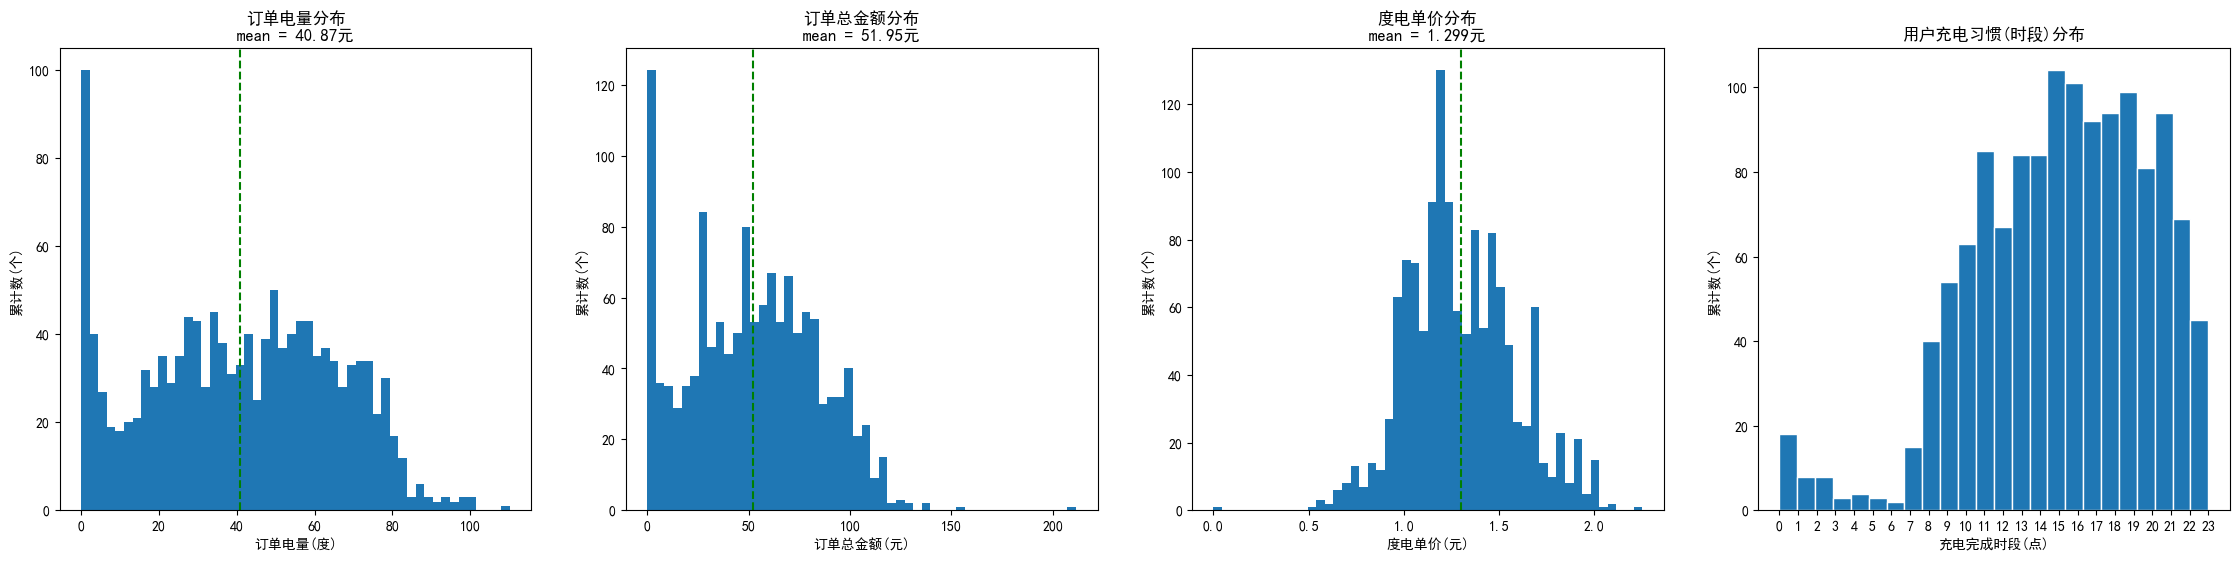

In [3]:
plt.figure(figsize=(7 * 4, 6))

# 订单电量及总金额频度分布
df_copy = df_target[["订单电量(度)", "订单总金额(元)"]].copy()
df_copy.loc[:, "度电单价(元)"] = df_copy.loc[:, "订单总金额(元)"] / df_copy.loc[:, "订单电量(度)"]

ax = plt.subplot(1, 4, 1)
ax.hist(df_copy["订单电量(度)"], bins=50)
mean = df_copy["订单电量(度)"].mean()
ax.axvline(x=mean, color='green', linestyle='--')
ax.set_xlabel("订单电量(度)")
ax.set_ylabel("累计数(个)")
ax.set_title("订单电量分布\nmean = %.2f元" % mean)

ax = plt.subplot(1, 4, 2)
ax.hist(df_copy["订单总金额(元)"], bins=50)
mean = df_copy["订单总金额(元)"].mean()
ax.axvline(x=mean, color='green', linestyle='--')
ax.set_xlabel("订单总金额(元)")
ax.set_ylabel("累计数(个)")
ax.set_title("订单总金额分布\nmean = %.2f元" % mean)

ax = plt.subplot(1, 4, 3)
ax.hist(df_copy["度电单价(元)"], bins=50)
mean = df_copy["度电单价(元)"].mean()
ax.axvline(x=mean, color='green', linestyle='--')
ax.set_xlabel("度电单价(元)")
ax.set_ylabel("累计数(个)")
ax.set_title("度电单价分布\nmean = %.3f元" % mean)

# 用户充电习惯（时段）
df_copy = df_target[df_target["充电完成时间"] > df_target["订单创建时间"]][["充电完成时间"]].copy()
df_copy.loc[:, "充电完成时段"] = df_copy.loc[:, "充电完成时间"].dt.hour

ax = plt.subplot(1, 4, 4)
ax.hist(df_copy["充电完成时段"], bins=24, edgecolor='w')
# mean = df_copy["充电完成时段"].mean()
# ax.axvline(x=mean, color='green', linestyle='--')
ax.set_xticks(np.linspace(0, 23, 24))
ax.set_xlabel("充电完成时段(点)")
ax.set_ylabel("累计数(个)")
ax.set_title("用户充电习惯(时段)分布")

plt.savefig(os.path.join(output_dir, '11.数据分布.png'), dpi=100, bbox_inches='tight')
plt.show()

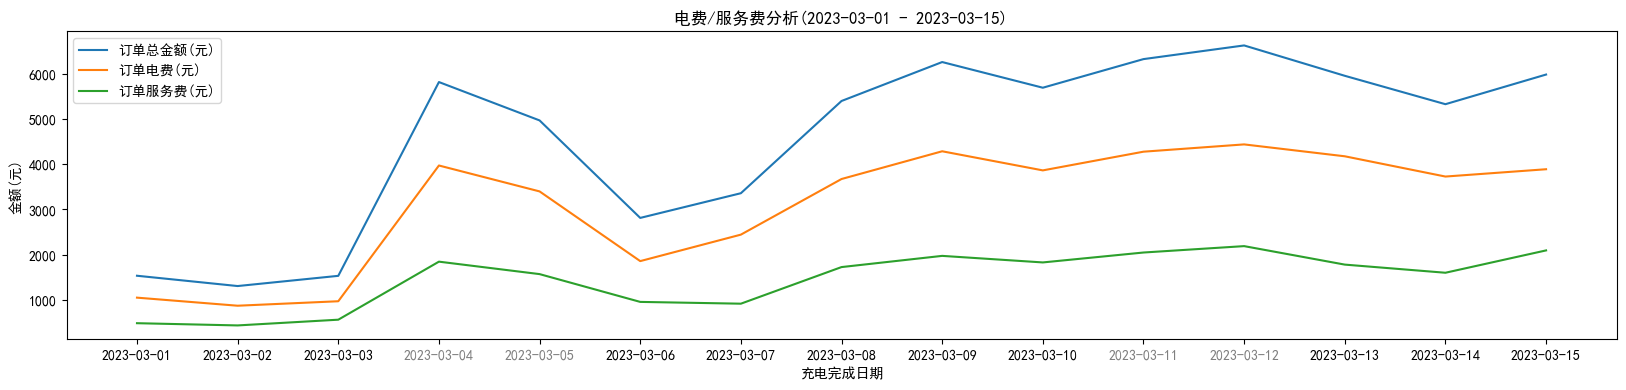

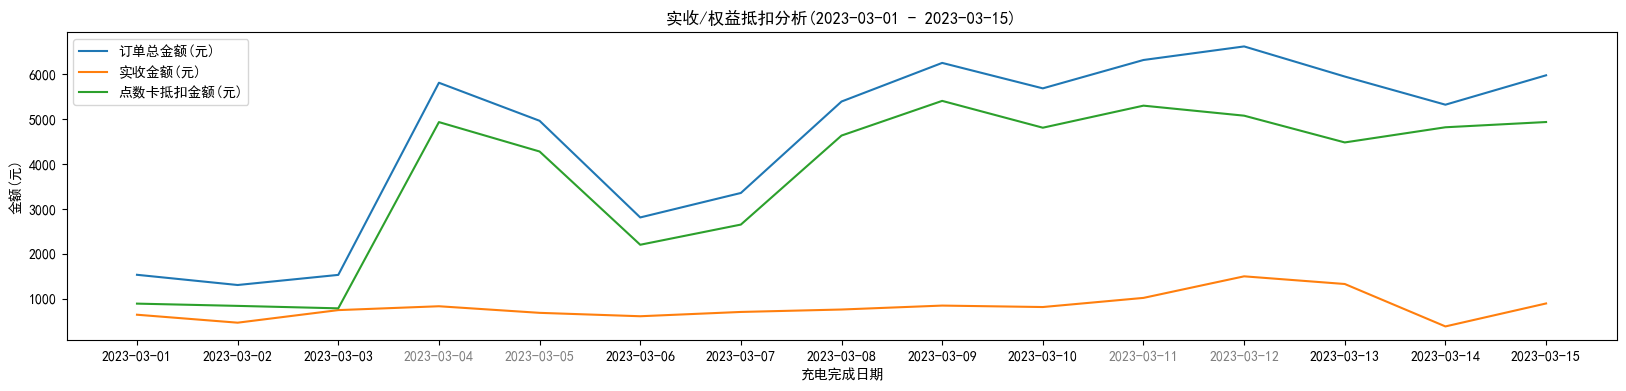

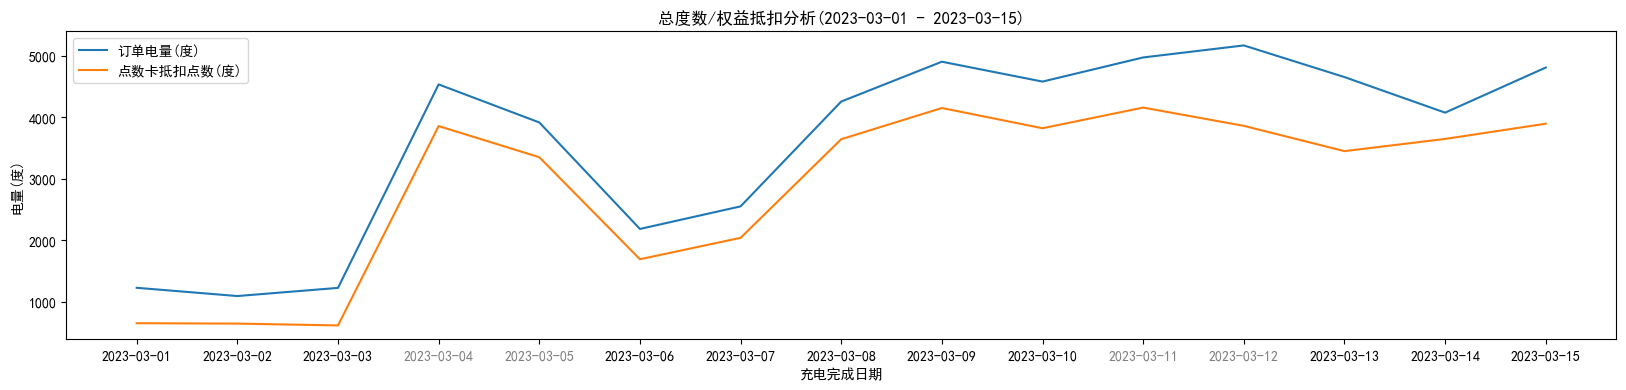

In [4]:
# 按【充电完成日期】分组统计
groups = df_target.groupby("充电完成日期", as_index=False)

# 电费/服务费
df_groups = groups[[
    "订单总金额(元)", 
    "订单电费(元)", 
    "订单服务费(元)", 
    ]].sum()

# 补空缺日期
idx = pd.Index(pd_date_range, name="充电完成日期")
df = df_groups.set_index("充电完成日期").reindex(idx, fill_value=0).reset_index()

_, ax = plt.subplots(figsize=(20, 4))
ax.plot(df["充电完成日期"], df["订单总金额(元)"], label='订单总金额(元)')
ax.plot(df["充电完成日期"], df["订单电费(元)"], label='订单电费(元)')
ax.plot(df["充电完成日期"], df["订单服务费(元)"], label='订单服务费(元)')
ax.set_xlabel("充电完成日期")
ax.set_ylabel("金额(元)")
ax.set_xticks(pd_date_range)
for idx in weekend_index:
    ax.get_xticklabels()[idx].set_color("grey")
ax.set_title('电费/服务费分析(%s - %s)' % (FROM_DATE, TO_DATE))
ax.legend()
plt.savefig(os.path.join(output_dir, '21.总金额-电费-服务费.png'), dpi=100, bbox_inches='tight')
plt.show()

# 实收/权益抵扣
df_groups = groups[[
    "订单总金额(元)", 
    "实收金额",
    "点数卡抵扣金额（元）", 
    ]].sum()

# 补空缺日期
idx = pd.Index(pd_date_range, name="充电完成日期")
df = df_groups.set_index("充电完成日期").reindex(idx, fill_value=0).reset_index()

_, ax = plt.subplots(figsize=(20, 4))
ax.plot(df["充电完成日期"], df["订单总金额(元)"], label='订单总金额(元)')
ax.plot(df["充电完成日期"], df["实收金额"], label='实收金额(元)')
ax.plot(df["充电完成日期"], df["点数卡抵扣金额（元）"], label='点数卡抵扣金额(元)')
ax.set_xlabel("充电完成日期")
ax.set_ylabel("金额(元)")
ax.set_xticks(pd_date_range)
for idx in weekend_index:
    ax.get_xticklabels()[idx].set_color("grey")
ax.set_title('实收/权益抵扣分析(%s - %s)' % (FROM_DATE, TO_DATE))
ax.legend()
plt.savefig(os.path.join(output_dir, '22.总金额-实收-抵扣.png'), dpi=100, bbox_inches='tight')
plt.show()

# 度电/抵扣点数
df_groups = groups[[
    "订单电量(度)", 
    "点数卡抵扣点数",
    ]].sum()

# 补空缺日期
idx = pd.Index(pd_date_range, name="充电完成日期")
df = df_groups.set_index("充电完成日期").reindex(idx, fill_value=0).reset_index()

_, ax = plt.subplots(figsize=(20, 4))
ax.plot(df["充电完成日期"], df["订单电量(度)"], label='订单电量(度)')
ax.plot(df["充电完成日期"], df["点数卡抵扣点数"], label='点数卡抵扣点数(度)')
ax.set_xlabel("充电完成日期")
ax.set_ylabel("电量(度)")
ax.set_xticks(pd_date_range)
for idx in weekend_index:
    ax.get_xticklabels()[idx].set_color("grey")
ax.set_title('总度数/权益抵扣分析(%s - %s)' % (FROM_DATE, TO_DATE))
ax.legend(loc='best')
plt.savefig(os.path.join(output_dir, '23.总度数-权益抵扣.png'), dpi=100, bbox_inches='tight')
plt.show()

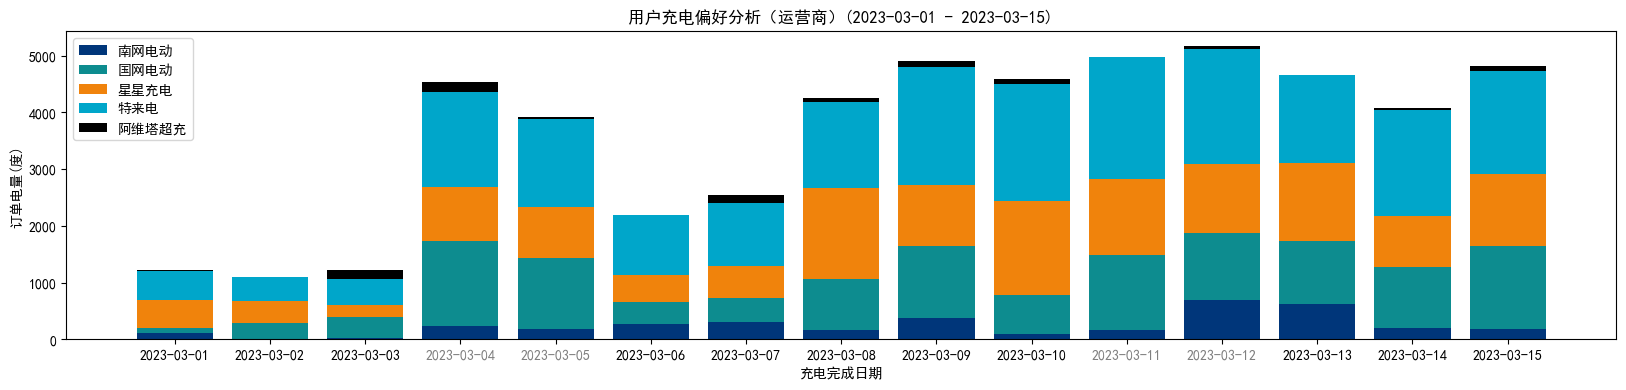

In [5]:
# 按【运营商名称】、【充电完成日期】分组统计
groups = df_target.groupby(["运营商名称", "充电完成日期"], as_index=False)

# 运营商使用倾向
df_groups = groups[[
    "订单电量(度)", 
    # "点数卡抵扣点数",
    ]].sum()

# 补空缺日期
mux = pd.MultiIndex.from_product([df_groups["运营商名称"].unique(), pd_date_range], names=["运营商名称", "充电完成日期"])
df = df_groups.set_index(["运营商名称", "充电完成日期"]).reindex(mux, fill_value=0).reset_index()

_, ax = plt.subplots(figsize=(20, 4))
tmp = np.zeros(shape=((TO_DATE - FROM_DATE).days + 1))
for k in df_groups["运营商名称"].unique():
    d = df[df["运营商名称"] == k]
    ax.bar(d["充电完成日期"], d["订单电量(度)"], label=k, bottom=tmp, color=[get_color_style(k)])
    tmp += d["订单电量(度)"].to_numpy()
del tmp
ax.set_xlabel('充电完成日期')
ax.set_ylabel('订单电量(度)')
ax.set_xticks(pd_date_range)

for idx in weekend_index:
    ax.get_xticklabels()[idx].set_color("grey")

ax.set_title('用户充电偏好分析（运营商）(%s - %s)' % (FROM_DATE, TO_DATE))
ax.legend(loc='best')
plt.savefig(os.path.join(output_dir, '31.用户充电偏好（运营商）.png'), dpi=100, bbox_inches='tight')
plt.show()

In [68]:
# 4.1 坏账预警
df_copy = df_toc_order[(df_toc_order["支付完成日期"].isna()) & (df_toc_order["充电完成日期"].isna() == False)][[
    "充电订单号",
    "用户编码",
    "用户昵称",
    "手机号【加密】",
    "运营商名称",
    "充电站名称",
    "订单电量(度)",
    "订单总金额(元)",
    "订单电费(元)",
    "订单服务费(元)",
    "订单创建日期",
    "充电完成日期",
]].copy()
df_copy.set_index("充电订单号", inplace=True)
df_copy.loc[:, "逾期天数"] = pd.to_datetime(TODAY_DATE) - df_copy.loc[:, "充电完成日期"]
df_copy.sort_values(["充电完成日期"], inplace=True)
df_copy.to_csv(os.path.join(output_dir, '41.坏账预警.csv'), encoding='utf_8_sig', sep=',')
# df_copy

In [90]:
# generate pptx from template
from pptx import Presentation
from pptx.shapes.placeholder import PicturePlaceholder, SlidePlaceholder, TablePlaceholder
from pptx.util import Pt

def adjust_picture_to_fit(ph_pic):
    # ph - PicturePlaceholder
    # print("origin(l, t, w, h):", ph_pic.left, ph_pic.top, ph_pic.width, ph_pic.height)
    
    l = ph_pic.left
    t = ph_pic.top
    w = ph_pic.width
    h = ph_pic.height

    ph_pic_width = ph_pic.width
    ph_pic_height = ph_pic.height
    (img_width, img_height) = ph_pic.image.size
    ph_aspect_ratio = float(ph_pic_width) / float(ph_pic_height)
    img_aspect_ratio = float(img_width) / float(img_height)

    ph_pic.crop_top = 0
    ph_pic.crop_left = 0
    ph_pic.crop_bottom = 0
    ph_pic.crop_right = 0

    # if the placeholder is "wider" in aspect, shrink the picture width while maintaining the image aspect ratio
    if ph_aspect_ratio > img_aspect_ratio:
        ph_pic.width = int(img_aspect_ratio * ph_pic_height)
        ph_pic.height = ph_pic_height
    # otherwise shrink the height
    else:
        ph_pic.width = ph_pic_width
        ph_pic.height = int(ph_pic_width / img_aspect_ratio)
    
    ph_pic.left = l + int((w - ph_pic.width) / 2)
    ph_pic.top = t + int((h - ph_pic.height) / 2)
    # print("adjust(l, t, w, h):", ph_pic.left, ph_pic.top, ph_pic.width, ph_pic.height)

# load template
prs = Presentation(os.path.join(root_dir, '公共充电业务日报模板.pptx'))

# 封面
slide = prs.slides[0]
contents = {
    10: r'公共充电业务日报',
    11: r'趋势时间周期 (%s - %s)' % (FROM_DATE, TO_DATE),
    12: '%s' % TODAY_DATE,
}
for ph in slide.placeholders:
    if isinstance(ph, SlidePlaceholder):
        ph.text = contents[ph.placeholder_format.idx]

# 数据分布页
slide = prs.slides[1]
for ph in slide.placeholders:
    if isinstance(ph, PicturePlaceholder):
        pic = ph.insert_picture(os.path.join(output_dir, '11.数据分布.png'))
        adjust_picture_to_fit(pic)

# 充电趋势（运营商）
slide = prs.slides[2]
for ph in slide.placeholders:
    if isinstance(ph, PicturePlaceholder):
        pic = ph.insert_picture(os.path.join(output_dir, '31.用户充电偏好（运营商）.png'))
        adjust_picture_to_fit(pic)

# 充电趋势（权益抵扣）
slide = prs.slides[3]
for ph in slide.placeholders:
    if isinstance(ph, PicturePlaceholder):
        pic = ph.insert_picture(os.path.join(output_dir, '23.总度数-权益抵扣.png'))
        adjust_picture_to_fit(pic)

# 充电趋势（电费服务费）
slide = prs.slides[4]
for ph in slide.placeholders:
    if isinstance(ph, PicturePlaceholder):
        pic = ph.insert_picture(os.path.join(output_dir, '21.总金额-电费-服务费.png'))
        adjust_picture_to_fit(pic)

# 坏账预警
slide = prs.slides[5]
df = pd.read_csv(os.path.join(output_dir, '41.坏账预警.csv'))
cols = [
    "充电订单号",
    # "用户编码",
    # "用户昵称",
    "运营商名称",
    # "充电站名称",
    # "订单电量(度)",
    "订单总金额(元)",
    "充电完成日期",
    "逾期天数",
]
df = df[cols]
# font.size = Pt(10)
for ph in slide.placeholders:
    if isinstance(ph, TablePlaceholder):
        gf = ph.insert_table(rows=len(df)+1, cols=len(cols))
        tb = gf.table
        # table titles
        for c in range(len(cols)):
            tb.cell(0, c).text = cols[c]
            tb.cell(0, c).text_frame.paragraphs[0].font.size = Pt(11)
        # table contents
        for r in range(len(df)):
            for c in range(len(tb.columns)):
                tb.cell(r+1, c).text = str(df.iloc[r, c])
                tb.cell(r+1, c).text_frame.paragraphs[0].font.size = Pt(11)

# 封底
# slide = prs.slides[6]

prs.save(os.path.join(output_dir, '公共充电业务日报.pptx'))